In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import Counter

%matplotlib inline

# Decision Trees and Ensemble Learning

## Credit risk scoring project

## Data preparation

In [2]:
remote_csv = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

!wget $remote_csv -O data.csv

--2023-10-21 15:22:41--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 178.21K  --.-KB/s    in 0.04s   

2023-10-21 15:22:41 (4.24 MB/s) - ‘data.csv’ saved [182489/182489]



In [3]:
df = pd.read_csv('data.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:
# clean the column/index names/values
df.columns = df.columns.str.lower().str.replace(' ', '_')

all_categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in all_categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.head().T

,0,1,2,3,4
status,1,1,2,1,1
seniority,9,17,10,0,0
home,1,1,2,1,1
time,60,60,36,60,36
age,30,58,46,24,26
marital,2,3,2,1,1
records,1,1,2,1,1
job,3,1,3,1,1
expenses,73,48,90,63,46
income,129,131,200,182,107


In [5]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [6]:
status_values = {
    1: "ok",
    2: "default",
    0: "unk",
}

df.status = df.status.map(status_values)

In [7]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)


In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [12]:
df = df[df.status != 'unk'].reset_index(drop=True)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
seed = 11

df_full_train, df_test = train_test_split(df, test_size=0.2,random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [16]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [17]:
del df_train['status']
del df_val['status']
del df_test['status']

In [18]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## Decision trees

In [19]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [20]:
xi = df_train.iloc[0].to_dict()

In [21]:
assess_risk(xi)

'ok'

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [23]:
seed = 1
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [24]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [25]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [26]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
# take the second column, otherwise we'd get a 2d array
# this is the probability of the customer belonging to the positive class
y_pred = dt.predict_proba(X_val)[:, 1]

In [28]:
roc_auc_score(y_val, y_pred)

0.6499327940713472

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

# this is overfitting - model memorized the data but failed to generalize
# tree is too deep (infinity) and gets too specific

1.0

In [30]:
dt = DecisionTreeClassifier(random_state=seed, max_depth=2)
dt.fit(X_train, y_train)

y_pred_train = dt.predict_proba(X_train)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_train)

y_pred_val = dt.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred_val)

auc_train, auc_val

# "decision stump" - only one decision level

(0.7054989859726213, 0.6685264343319367)

In [31]:
from sklearn.tree import export_text

In [32]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

# this uses one-hot encoding
# the tree depth will the output, e.g. DT with depth=1 is
# |--- records=no <= 0.50
# |   |--- class: 1
# |--- records=no >  0.50
# |   |--- class: 0

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## Decision tree learning algorithm

* use condition node, where some feature > some threshold
* split the dataset into 2 parts - you get kinda a binary tree
* 

In [33]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [34]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [35]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

# an example where threshold is 4000
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

display(df_left)
print(df_left.status.value_counts(normalize=True))
display(df_right)
print(df_left.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


In [36]:
from IPython.display import display

In [37]:
# split evaluation criteria - below shows the splits

for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))

    print()

0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [38]:
# misclassification rate: errors out of total predictions. tells us the quality of the split
# e.g. say the left branch/decision is "default", the right branch/decision is "ok"
# misclassification rate will be the ratio of default : ok.

# to determine the best threshold, iterate over the thresholds and determine the "impurity"
# (the misclassification rate) of the left and right branches, then get the average. the
# threshold that results in the lowest average impurity is the best threshold.

# decision tree stopping criteria
#  * group already pure
#  * tree reached depth limit 
#  * group too small to split

## Decision tree parameter tuning

## Ensemble learning and random forest

random forest: say there are n features, we don't want to train the same model over and over.
instead, pick some random m features where m < n and train the model. then take average of
the probabilities.

we'll need to tune the random forest because it's basically a flow chart. this lesson shows 
how to do that.

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [41]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [42]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [43]:
rf.predict_proba(X_val)[[0]]

array([[0.9, 0.1]])

In [44]:
# how does performance of model change as we change the estimators?
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores.head()

,n_estimators,auc
0,10,0.774473
1,20,0.803532
2,30,0.815075
3,40,0.815686
4,50,0.817082


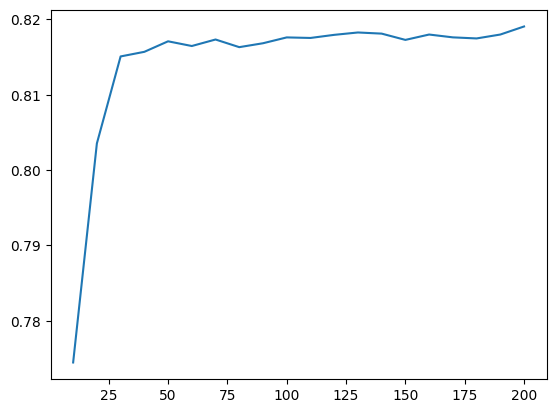

In [45]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [46]:
# now we want to see what happens if we limit the tree's depth

scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


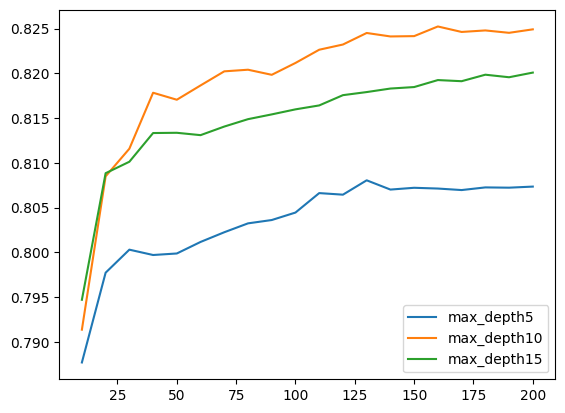

In [47]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth%d' % d)

plt.legend()

# max_depth=10 has the highest auc, therefore it's the best depth to use.

In [48]:
# let's instead try with different sample leafs
max_depth = 10

scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791365
1,1,20,0.808496
2,1,30,0.811584
3,1,40,0.817839
4,1,50,0.817058


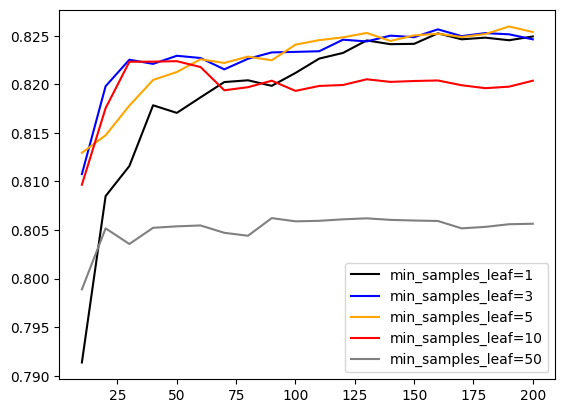

In [49]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

# 1, 3, 5 are the best, 10 is less good, and 50 is the worst

In [50]:
# now we know the best max_depth and min_sample_leaf, so now we can train our model with
# these tuned parameters
min_samples_leaf = 3

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

## Gradient boosting and XGBoost

random forest - combine multiple independent models (can be parallelized)

boosting - different way to combine multiple models into ensemble (sequential)
  * train first model
  * get predictions, look at errors
  * based on errors, train another model
  * get predictions, look at errors
  * ... etc.
  * finally, combine multiple predictions into final prediction


In [51]:
import xgboost as xgb

In [60]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [65]:
xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1,  # same as min_samples_leaf, # observations per node
    'objective': 'binary:logistic',  # same as logistic regression, e.g. sigmoid
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,
}

trees_to_grow = 10

model = xgb.train(xgb_params, dtrain, num_boost_round=trees_to_grow)

/Users/carise/.pyenv/versions/3.10.6/envs/dtc-mlzoompcamp/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [15:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)


In [66]:
y_pred = model.predict(dval)

In [67]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [68]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [75]:
%%capture output

xgb_params = {
    'eta': 0.3, # learning rate
    'max_depth': 6,
    'min_child_weight': 1,  # same as min_samples_leaf, # observations per node

    'objective': 'binary:logistic',  # same as logistic regression, e.g. sigmoid
    'eval_metric': 'auc',
    
    'nthreads': 8,
    'seed': 1,
    'verbosity': 1,
}

trees_to_grow = 10

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [76]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [77]:
df_score = parse_xgb_output(output)

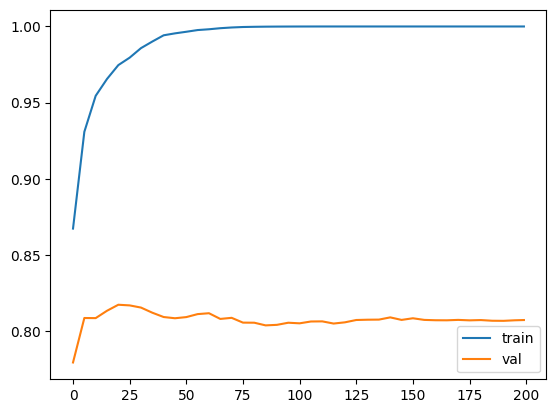

In [81]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# we can see some overfitting starting around 60 iterations (trees)

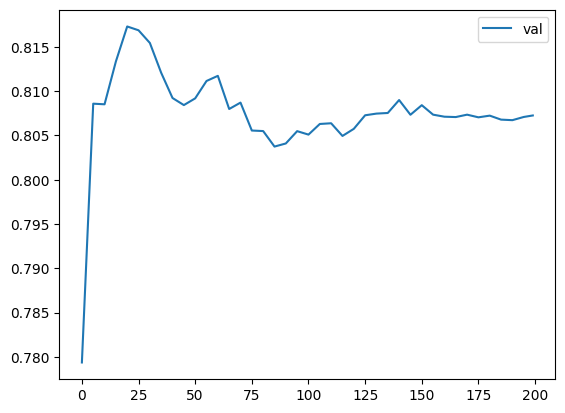

In [80]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## XGBoost parameter tuning

from last lesson we trained a model, and we can see from the validation that we get around
82% around 25 trees, but the auc/model performance declined after that.

XGBoost parameters
 * eta = learning rate (aka size of step): how much we correct errors from previous iteration of model
 * 

In [84]:
%%capture output

scores = {}

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [87]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [88]:
%%capture output

scores = {}

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [89]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [90]:
del scores['max_depth=10']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


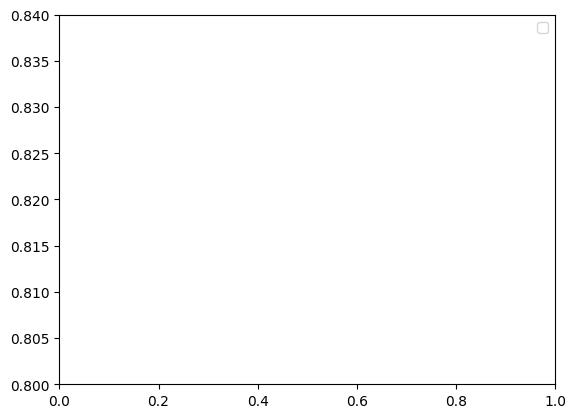

In [91]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()